In [4]:
import pandas as pd 
import numpy as np 
from scipy.signal import csd
import networkx as nx 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 


In [50]:
covid_data= pd.read_csv("data/us.csv")
n_rows = len(covid_data)
daily_cases = covid_data["cases"].diff(1)
daily_deaths = covid_data["deaths"].diff(1)
covid_data["daily_cases"] = daily_cases
covid_data["daily_death"] = daily_deaths
covid_data = covid_data.fillna(0)
## replace initial NaN with 0 
# covid_data["daily_cases"][0] = 0 
# covid_data["daily_death"][0] = 0 


In [51]:
covid_data

,date,cases,deaths,daily_cases,daily_death
0,2020-01-21,1,0,0.0,0.0
1,2020-01-22,1,0,0.0,0.0
2,2020-01-23,1,0,0.0,0.0
3,2020-01-24,2,0,1.0,0.0
4,2020-01-25,3,0,1.0,0.0
...,...,...,...,...,...
1153,2023-03-19,103784916,1133826,1424.0,0.0
1154,2023-03-20,103794703,1133964,9787.0,138.0
1155,2023-03-21,103813076,1134177,18373.0,213.0
1156,2023-03-22,103864888,1134913,51812.0,736.0


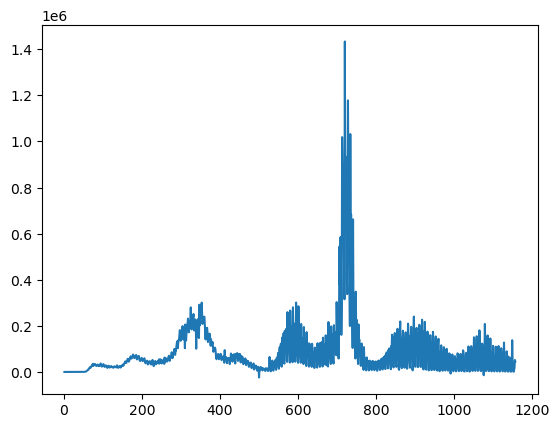

In [7]:
plt.plot(covid_data["daily_cases"])
#plt.plot(covid_data["deaths"])

In [ ]:
have_ran = True 
def dateNum(date):
    m_day = datetime.date(2022,6,2)
    parts = date.split("-")
    day = datetime.date(int(parts[0]),int(parts[1]),int(parts[2]))
    return (m_day - day).days
if not have_ran:
    tweets = pd.read_csv("data/tweetid_userid_keyword_sentiments_emotions_United States.csv")
    tweets["emotion"] = tweets["emotion"].fillna("N")
    tweets_data = dict() 
    def convertor(x):
        if(x in [-2,-1,0,1,2]):
            return [-2,-1,0,1,2].index(x)
        elif(x in ["N", "S", "H", "A","F"]):
            return ["N", "S", "H", "A","F"].index(x)+5
        else:
            print("Oh no this shound't happen at ", x )
            

    for i in range(n_tweets):
        day = tweets["tweet_timestamp"][i].split(" ")[0]
        sent = tweets["sentiment"][i] 
        emote = tweets["emotion"][i] 
        if(day in tweets_data):
            tweets_data[day][convertor(sent)] += 1
            tweets_data[day][convertor(emote)] += 1
        else: 
            arr = [0 for i in range(10)]
            arr[convertor(sent)] = 1 
            arr[convertor(emote)] = 1
            tweets_data[day] = arr.copy() 
    n = len(tweets_data)
    dates = ["" for i in range(n)] 


    measurement = np.zeros((n, 10))

    for tweet in tweets_data:
        i = dateNum(tweet)
        measurement[i, :] = tweets_data[tweet]
        dates[i] = tweet 
    twitter_cleaned = pd.DataFrame(measurement,
                                columns=["-2_sent","-1_sent","0_sent",
                                            "1_sent","2_sent",
                                            "N", "S", "H", "A","F"] )
    twitter_cleaned.insert(0, "Date", dates)
    twitter_cleaned.to_csv("data/twitter_aggr.csv")

In [67]:
covid_data

,date,cases,deaths,daily_cases,daily_death
0,2020-01-21,1,0,0.0,0.0
1,2020-01-22,1,0,0.0,0.0
2,2020-01-23,1,0,0.0,0.0
3,2020-01-24,2,0,1.0,0.0
4,2020-01-25,3,0,1.0,0.0
...,...,...,...,...,...
1153,2023-03-19,103784916,1133826,1424.0,0.0
1154,2023-03-20,103794703,1133964,9787.0,138.0
1155,2023-03-21,103813076,1134177,18373.0,213.0
1156,2023-03-22,103864888,1134913,51812.0,736.0


In [66]:
twitter_data = pd.read_csv("data/twitter_aggr.csv")
twitter_data = twitter_data.drop(columns="Unnamed: 0")
twitter_data = twitter_data.sort_values(by="Date")
twitter_data

,Date,-2_sent,-1_sent,0_sent,1_sent,2_sent,N,S,H,A,F
856,2020-01-28,421.0,6131.0,1333.0,1409.0,33.0,1333.0,258.0,1442.0,1746.0,4548.0
855,2020-01-29,780.0,9195.0,2325.0,2286.0,42.0,2325.0,382.0,2328.0,2838.0,6755.0
854,2020-01-30,736.0,9647.0,2162.0,2478.0,40.0,2162.0,365.0,2518.0,2946.0,7072.0
853,2020-01-31,632.0,9270.0,2046.0,2339.0,46.0,2046.0,380.0,2385.0,2850.0,6672.0
852,2020-02-01,438.0,6589.0,1602.0,1783.0,42.0,1602.0,266.0,1825.0,2108.0,4653.0
...,...,...,...,...,...,...,...,...,...,...,...
4,2022-05-29,1574.0,11353.0,2680.0,4383.0,183.0,2680.0,1399.0,4566.0,6208.0,5320.0
3,2022-05-30,1625.0,11247.0,2787.0,4232.0,159.0,2787.0,1328.0,4391.0,6219.0,5325.0
2,2022-05-31,1959.0,14878.0,3786.0,5464.0,225.0,3786.0,1675.0,5689.0,7904.0,7258.0
1,2022-06-01,2013.0,14136.0,3430.0,5594.0,300.0,3430.0,1558.0,5894.0,7832.0,6759.0


In [93]:
max_tweet_day = max(twitter_data.sum(axis=1, numeric_only=True))
max_covid_day = max(covid_data["daily_cases"])
max_death_day = max(covid_data["daily_death"])

In [94]:
z_mat = np.zeros((12,12,129), dtype=np.complex64)
keys = {0 : (1/max_tweet_day) * twitter_data["-2_sent"], 
        1 : (1/max_tweet_day) * twitter_data["-1_sent"],
        2 : (1/max_tweet_day) * twitter_data["0_sent"],
        3 : (1/max_tweet_day) * twitter_data["1_sent"],
        4 : (1/max_tweet_day) * twitter_data["2_sent"],
        5 : (1/max_tweet_day) * twitter_data["N"],
        6 : (1/max_tweet_day) * twitter_data["S"],
        7 : (1/max_tweet_day) * twitter_data["H"],
        8 : (1/max_tweet_day) * twitter_data["A"],
        9 : (1/max_tweet_day) * twitter_data["F"],
        10 : (1/max_covid_day) * covid_data["daily_cases"][8:865],
        11 : (1/max_death_day) * covid_data["daily_death"][8:865]}

In [95]:
for i in range(12):
    for j in range(12):
        freq, z = csd(keys[i], keys[j])
        z_mat[i,j,:] = z 

In [96]:
mean_real_part = np.zeros((12,12))
mean_imag_part = np.zeros((12,12))
for i in range(12):
    for j in range(12):
        mean_real_part[i,j] = np.mean([np.real(k) for k in z_mat[i,j,:]] )
        mean_imag_part[i,j] = np.mean([np.imag(k) for k in z_mat[i,j,:]] )

In [97]:
np.max(covid_data["daily_cases"])

1433977.0

In [107]:
mean_imag_part

array([[ 0.00000000e+00, -5.60924127e-06, -3.19783521e-06,
        -8.40168923e-06, -4.00172837e-07, -3.19783521e-06,
        -1.16765204e-06, -8.80186144e-06, -1.16854153e-06,
        -3.27304815e-06, -1.82231670e-05, -9.63955536e-05],
       [ 5.60924127e-06,  0.00000000e+00, -2.05155247e-05,
        -6.17966143e-05, -3.98920611e-06, -2.05155247e-05,
        -7.30686634e-06, -6.57858327e-05,  1.08446857e-05,
         2.07142102e-06, -1.64293044e-04, -7.21651071e-04],
       [ 3.19783521e-06,  2.05155247e-05,  0.00000000e+00,
        -1.09822258e-05, -1.23772622e-06, -3.18206320e-22,
         2.50711878e-07, -1.22199517e-05,  1.40005759e-05,
         9.46207365e-06, -2.11048446e-05, -1.35595037e-04],
       [ 8.40168923e-06,  6.17966143e-05,  1.09822258e-05,
         0.00000000e+00, -1.56560441e-06,  1.09822258e-05,
         4.27410487e-06, -1.56560441e-06,  3.40161387e-05,
         3.19080573e-05,  4.50802363e-05, -6.85554332e-05],
       [ 4.00172837e-07,  3.98920611e-06,  1.2377262

In [108]:
graph_iter_0 = np.zeros((12,12))
thres_rl = 2e-4
thres_im = 1e-5
for i in range(12):
    for j in range(12):
        if(mean_real_part[i,j] > thres_rl and mean_imag_part[i,j] > thres_im):
            graph_iter_0[i,j] = 1 

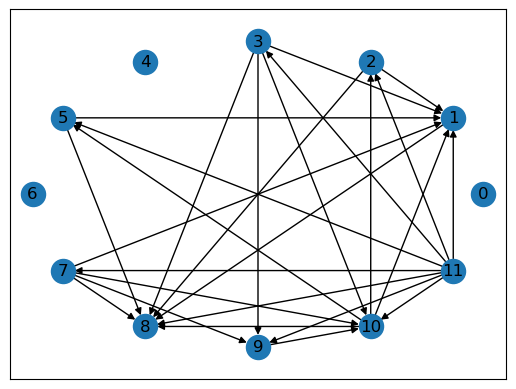

In [109]:
G = nx.DiGraph(graph_iter_0)
ly = nx.circular_layout(G)
nx.draw_networkx(G, pos=ly)